# Exploratory data analysis and designing the clustering algorithm

In [728]:
!pip3 install matplotlib
!pip3 install folium
!pip3 install scikit-learn
!pip3 install pandas
!pip3 install shapely
!pip3 install geopy

In [729]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import numpy as np
from shapely.geometry import MultiPoint
from geopy.distance import great_circle
import uuid
import math
import folium


In [730]:
# Read the compressed CSV file and display the first few rows
df = pd.read_csv('tours.csv.gz', compression='gzip')
df.head()


,user_id,latitude,longitude
0,0280088d,52.552575,13.443113
1,0280088d,52.552958,13.442784
2,a6468bc1,52.457977,12.843970
3,0280088d,52.552796,13.441866
4,49b2ce0a,52.486855,13.551305


In [731]:
# Count the number of data points and unique user_ids
print("Number of data points is", df.shape[0])

unique_user_ids = df['user_id'].nunique()
print(f"Number of unique user_ids: {unique_user_ids}")
# Check the data types of columns
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

# Calculate summary statistics
df.describe()

Number of data points is 19654
Number of unique user_ids: 9632
user_id       object
latitude     float64
longitude    float64
dtype: object
user_id      0
latitude     0
longitude    0
dtype: int64


,latitude,longitude
count,19654.000000,19654.000000
mean,52.493997,13.369972
std,0.097182,0.200209
min,52.186911,12.581296
25%,52.432550,13.270148
50%,52.499338,13.393642
75%,52.546528,13.476121
max,52.818415,14.017925


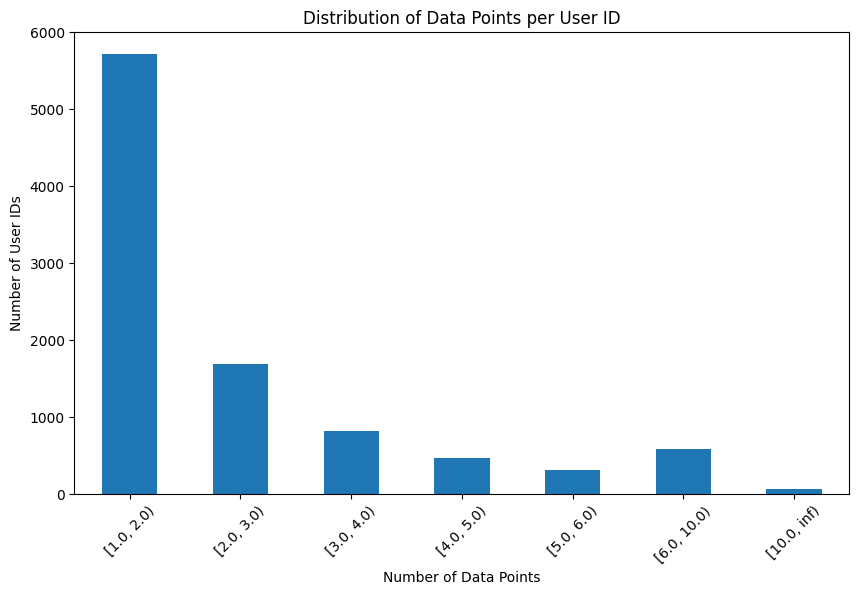

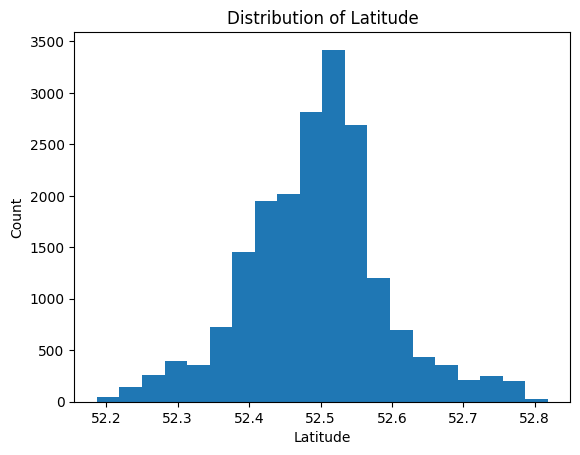

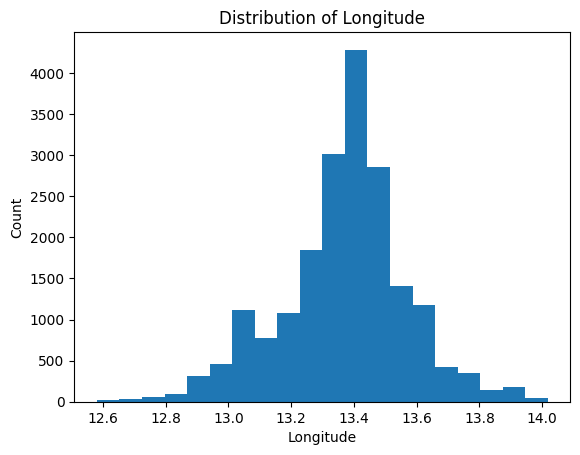

In [732]:
# Count the number of data points per user_id
data_points_per_user = df['user_id'].value_counts()

# Count the number of user_ids for each count of data points
data_points_counts = data_points_per_user.value_counts().sort_index()

# Group the counts into sensible ranges
ranges = [1, 2, 3, 4, 5, 6, 10, float('inf')]
grouped_counts = data_points_counts.groupby(pd.cut(data_points_counts.index, ranges, right=False)).sum()

# Plot the distribution
plt.figure(figsize=(10, 6))
grouped_counts.plot(kind='bar')
plt.xlabel('Number of Data Points')
plt.ylabel('Number of User IDs')
plt.title('Distribution of Data Points per User ID')
plt.xticks(rotation=45)
plt.show()

# Plot histogram of latitude
plt.hist(df['latitude'], bins=20)
plt.xlabel('Latitude')
plt.ylabel('Count')
plt.title('Distribution of Latitude')
plt.show()

# Plot histogram of longitude
plt.hist(df['longitude'], bins=20)
plt.xlabel('Longitude')
plt.ylabel('Count')
plt.title('Distribution of Longitude')
plt.show()



In [733]:
# DBSCAN Clustering
df['latitude_scaled'] = np.radians(df['latitude'])
df['longitude_scaled'] = np.radians(df['longitude'])
kms_per_radian = 6371.0088
epsilon = 1 / kms_per_radian
min_samples = 5  # minimum number of samples in a cluster
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples, algorithm='ball_tree', metric="haversine")
df['cluster_label'] = dbscan.fit_predict(df[['latitude_scaled', 'longitude_scaled']])

# Filter out remote ("noisy") points
df_filtered = df[df['cluster_label'] != -1]

# Create cluster groups
cluster_counts = df_filtered['cluster_label'].value_counts()
sorted_clusters = cluster_counts.sort_values(ascending=False)
sorted_clusters


cluster_label
0     17818
3        99
6        87
18       85
4        55
      ...  
67        5
12        5
77        5
45        5
78        5
Name: count, Length: 79, dtype: int64

In [734]:
def get_centermost_point(cluster):
    '''
    This function returns the center-most point from a cluster by taking a set of points (i.e., a cluster) 
    and returning the point within it that is nearest to some reference point (in this case, the cluster’s centroid):
    '''
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

cluster_labels = dbscan.labels_
num_clusters = len(set(cluster_labels))
coords = df[['latitude', 'longitude']].values

clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters) if len(coords[cluster_labels == n]) > 0]) 
centermost_points = clusters.map(get_centermost_point)
centermost_points

0       (52.49659886497629, 13.37248445759664)
1      (52.67175581715572, 13.164288006590008)
2       (52.55324380804789, 12.99411459500698)
3      (52.30389873734576, 13.254080503390972)
4       (52.59986880712316, 13.89600620397986)
                        ...                   
74     (52.46339768473499, 13.854190570090186)
75    (52.251242102806266, 12.957468742763496)
76      (52.50065310471778, 12.64648317097278)
77     (52.458194960948816, 12.86914763642015)
78     (52.20840818536819, 13.797767909119816)
Length: 79, dtype: object

In [735]:
# Include the outlier data points into a group, if the individual is not already in a cluster
users_without_cluster = []
for user_id in df[df['cluster_label'] == -1]['user_id'].unique():
    if df[df['user_id'] == user_id]['cluster_label'].nunique() == 1:
        users_without_cluster.append(user_id)
print("Users without a cluster:", len(users_without_cluster))

# Assign the closest cluster for users without a cluster by finding the closest one from all the users points.
for user_id in users_without_cluster:
    user_coords = df.loc[df['user_id'] == user_id, ['latitude', 'longitude']].values
    closest_cluster = min(centermost_points, key=lambda point: min(great_circle(point, coord).m for coord in user_coords))
    closest_cluster_idx = centermost_points[centermost_points == closest_cluster].index[0]
    df.loc[df['user_id'] == user_id, 'cluster_label'] = closest_cluster_idx


Users without a cluster: 362


In [736]:
# Drop the rows that have cluster_label -1. 
# At this point, users that have -1 label, already belong to another cluster, so these outliers can be neglected.
df = df[df['cluster_label'] != -1]

# Calculate distances for each row
df['distance'] = df.apply(lambda row: great_circle(
    (row['latitude'], row['longitude']),
    centermost_points[row['cluster_label']]
).kilometers, axis=1)

print(df.shape)
# Get the indices of the rows with the smallest distance for each user_id
min_distance_indices = df.groupby('user_id')['distance'].idxmin()

# Filter the DataFrame to keep only the rows with the smallest distance for each user_id
df = df.loc[min_distance_indices]
print(df.shape)

(19342, 7)
(9632, 7)


In [737]:
# Create a dictionary mapping cluster labels to starting point IDs and add starting points
start_point_ids = {index: uuid.uuid4() for index in centermost_points.index}

df['start_point_id'] = df['cluster_label'].map(start_point_ids)
df['start_point_latitude'] = df['cluster_label'].map(lambda x: centermost_points[x][0])
df['start_point_longitude'] = df['cluster_label'].map(lambda x: centermost_points[x][1])

df.head()

,user_id,latitude,longitude,latitude_scaled,longitude_scaled,cluster_label,distance,start_point_id,start_point_latitude,start_point_longitude
9194,0000571b,52.464814,13.858726,0.915684,0.241880,74,0.345257,9d5e5d7d-4cd7-48ca-8b91-d717de32d206,52.463398,13.854191
8224,0001699f,52.555009,13.424564,0.917258,0.234303,0,7.389014,6c4b46a6-243c-462c-97ef-476ceb2f53e1,52.496599,13.372484
10627,00060476,52.484604,13.311919,0.916029,0.232337,0,4.312075,6c4b46a6-243c-462c-97ef-476ceb2f53e1,52.496599,13.372484
7164,0006963f,52.719423,13.259965,0.920128,0.231430,0,25.915692,6c4b46a6-243c-462c-97ef-476ceb2f53e1,52.496599,13.372484
17506,000e8618,52.470330,13.306235,0.915780,0.232238,0,5.353311,6c4b46a6-243c-462c-97ef-476ceb2f53e1,52.496599,13.372484


Generating groups within the clusters

In [738]:
max_group_size = 40

group_data = []
unique_clusters = df['cluster_label'].unique().tolist()

for cluster_label in unique_clusters:
    cluster_points = df[df['cluster_label'] == cluster_label]
    cluster_members = cluster_points['user_id'].tolist()
    unique_users = cluster_points['user_id'].nunique()
    num_groups = max(1, math.ceil(unique_users / max_group_size))
    group_size = math.ceil(unique_users / num_groups)
    for _ in range(num_groups):
        group_id = str(uuid.uuid4())
        members = []
        if unique_users >= group_size:
            members.extend(cluster_members[:group_size])
            cluster_members = cluster_members[group_size:] 
            unique_users -= group_size
        else:
            members.extend(cluster_members)
            cluster_members = []
            unique_users = 0
        group_data.append({'cluster_label': cluster_label, 'group_id': group_id, 'members': members, 'group_size': len(members)})
# Assign group_id and potential_group_members to df
df['group_id'] = None
df['potential_group_members'] = None
df['group_size'] = None
for group in group_data:
    members = group['members']
    group_id = group['group_id']
    group_size = group['group_size']
    df.loc[df['user_id'].isin(members), 'group_id'] = group_id
    df.loc[df['user_id'].isin(members), 'potential_group_members'] = ','.join(members)
    df.loc[df['user_id'].isin(members), 'group_size'] = group_size

In [739]:
# Check that we didn't lose any users and that every  user has a group appointed
print("Number of users:", df.shape[0])
print("Users without group:", df['group_id'].isna().sum())

Number of users: 9632
Users without group: 0


In [740]:
# Check statistics of mean and max distance
df['int_distance'] = df['distance'].astype(int)
mean_distance = df['int_distance'].mean()
print("Mean distance among all users:", mean_distance)
median_distance = np.median(df['int_distance'])
print("Median distance (translated to integers):", median_distance)

max_distance = df['distance'].max()
user_with_max_distance = df.loc[df['distance'] == max_distance, 'user_id'].iloc[0]
print("User with max distance:", user_with_max_distance)
print("Distance", df.loc[df['user_id'] == user_with_max_distance, 'distance'].iloc[0])

smallest_group_count = df['group_id'].value_counts().min()
print("Count of smallest group:", smallest_group_count)


Mean distance among all users: 10.09406146179402
Median distance (translated to integers): 7.0
User with max distance: d95b5cb5
Distance 36.05289511681109
Count of smallest group: 3


In [741]:
# Create a folium map centered around the mean latitude and longitude
map_center = [df['start_point_latitude'].mean(), df['start_point_longitude'].mean()]
m = folium.Map(location=map_center, zoom_start=12)

# Add markers for each cluster center
for cluster_center in centermost_points:
    folium.Marker(location=cluster_center).add_to(m)
# Display the map
m